# PDX Tumors Subtyping

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [5]:
adata = cr.read('../../out/PDX-tumors/adata_02.h5ad')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [2]:
X_magic = cr.read('../../out/PDX-tumors/X_magic_02.h5ad')
X_magic

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 928 × 10885
    obs: 'Clusters', '_X', '_Y', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mito', 'pct_dropout_by_counts-Tumor 1', 'ambient-Tumor 1', 'dropkick_coef-Tumor 1', 'pct_dropout_by_counts-Tumor 2', 'ambient-Tumor 2', 'dropkick_coef-Tumor 2', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    uns: 'pca', 'specialists_pca_d

In [7]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [8]:
adata.write_h5ad('../../out/PDX-tumors/adata_03.h5ad')

# Subtyping with Archetype Signatures

In [9]:
adata = cr.read('../../out/PDX-tumors/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


## Using Mazebox to generate archetype scores

In [10]:
sig_matrix = pd.read_csv('../../out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)


In [11]:
# import seaborn as sns
# max_subtype = []
# max_v = []
# sig_matrix_copy = sig_matrix.copy()
# for i,r in sig_matrix.iterrows():
#     maxi = r.idxmax()
#     maxv = r.max()
#     max_subtype.append(maxi) 
#     max_v.append(maxv)
# sig_matrix_copy['max_subtype'] = max_subtype
# sig_matrix_copy['max'] = max_v

# plt.figure(figsize=(5,30))
# sig_matrix_copy = sig_matrix_copy.sort_values(by = ['max_subtype','max'], ascending=[True, False])
# sig_matrix_copy = sig_matrix_copy[['SCLC-A','SCLC-A2','SCLC-N','SCLC-P','SCLC-Y']]
# sns.heatmap(sig_matrix_copy, cmap='viridis', yticklabels = True)
# plt.xticks(rotation = 90)
# plt.title(f'Log-transformed Archetype Expression Profiles')
# plt.tight_layout()
# # plt.savefig(op.join(outdir,f'figures/Archetypes/sig_matrix_logfc.pdf'))
# plt.show()
# plt.close()

# sig_matrix_copy.to_csv('../data/sig_matrix_ParTI.csv')

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (34, 5)
Tumor data shortened to genes in gene list...
(520, 34)
Tumor data subsetting complete.


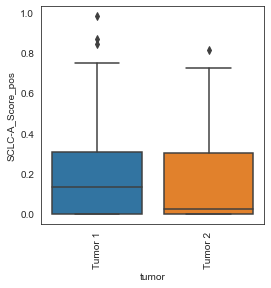

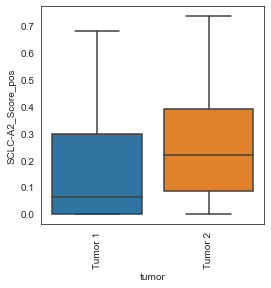

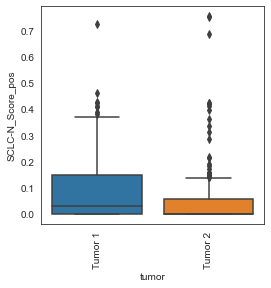

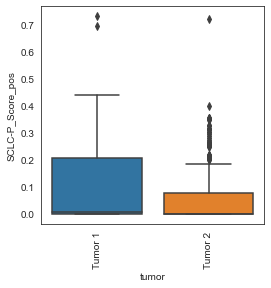

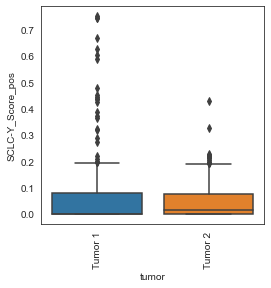

In [12]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'tumor',velocity=False)


In [13]:
from sklearn.manifold import LocallyLinearEmbedding
def _archetype_diagram_no_arrows(_adata, score_name, color, figsize, order, multiplier,fname,
                                 sizes = None, alpha = .3, s = 30, color_dict = None, norm = 'scale'):
    # X = subtype scores for each subtype (pd dataframe)
    n_samples = len(_adata.obs_names)

    n_types = len(sig_matrix.columns)
    subtypes = sig_matrix.columns
    X = _adata.obs[[f"{x}{score_name}" for x in subtypes]]
    top = X.sum().sort_values(ascending=False)[:3]  # return a list of n largest element
    print(top.index)

    # normalize X to sum to 1 (makes sure that the data fits within the archetype diagram with I matrix = vertices
    X_norm = pd.DataFrame(columns=X.columns)
    if norm == 'scale':
        for i, r in X.iterrows():
            if r.sum() == 0:
                X_norm = X_norm.append(r)
            else:
                X_norm = X_norm.append(r / r.sum())
    elif norm == 'max':
        max = X.max().max()
        X_norm = X / max
    elif norm == 'None':
        X_norm = X

    X = X_norm.fillna(0)
    if type(order) != type(None):
        X = X[[f"{x}{score_name}" for x in order]]
        subtypes = order
    else:
        order = subtypes

    ident = np.identity(n_types)
    for i, x in enumerate(subtypes):
        X = X.append(pd.DataFrame(np.array(ident[i]), index=X.columns, columns=[x]).T)

    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=4, method='modified', eigen_solver='dense')
    X_transformed = embedding.fit_transform(X[-n_types:])
    X_transformed = X_transformed.T

    X_df_data = embedding.transform(X[:-n_types])
    X_df_data = X_df_data.T

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    plt.scatter(X_df_data[0], X_df_data[1], c=c, zorder=1, alpha=alpha, s=s)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                zorder=2, s=sizes)
    plt.axis('tight')
    plt.savefig(f'./figures/{fname}.pdf')
    plt.show()
    plt.close()
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    sns.kdeplot(X_df_data[0], X_df_data[1], cmap="Reds", shade=True, bw=.15)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    plt.axis('tight')
    plt.show()
    plt.close()


Index(['SCLC-A2_Score', 'SCLC-A_Score', 'SCLC-Y_Score'], dtype='object')


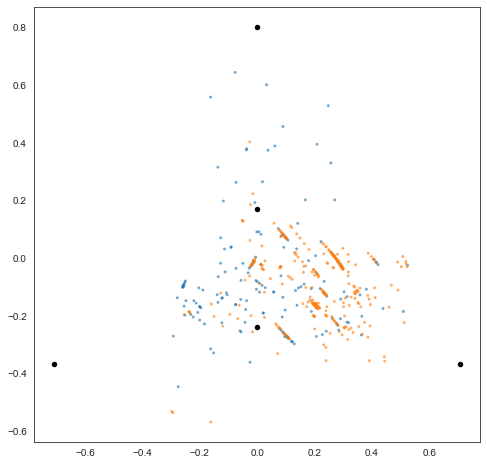

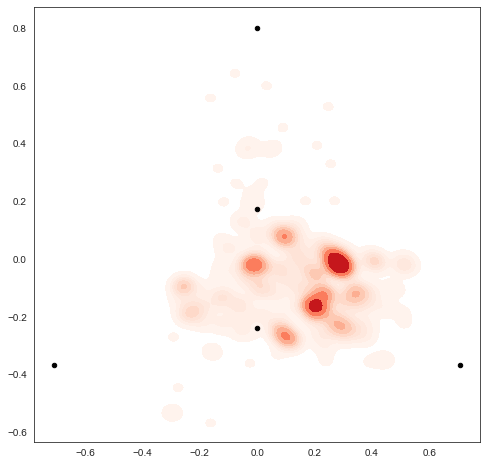

In [14]:
color_dict = {}
for i,c in enumerate(sorted(list(set(adata_small.obs['tumor'])))):
    if i == 7:     color_dict[c] = sns.color_palette('tab10')[9] #skip grey
    else:
        color_dict[c] = sns.color_palette('tab10',8)[i]
cmap = 'jet'
_archetype_diagram_no_arrows(adata_small, color_dict=color_dict,color='tumor',fname = 'tumor_archetype_space',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',
                        multiplier=1, figsize=(8,8), score_name = '_Score', alpha = .5, s = 4, sizes = 20)


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

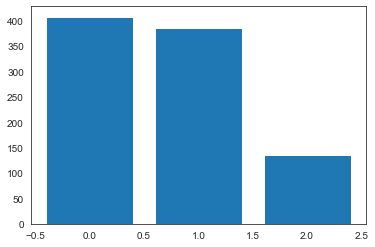

In [15]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [16]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [17]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['tumor']).style.background_gradient(cmap='viridis')

tumor,Tumor 1,Tumor 2
arc_pheno,,
SCLC-A,44,106
SCLC-A2,41,137
SCLC-A2_SCLC-A,6,12
SCLC-A2_SCLC-N,3,4
SCLC-A2_SCLC-P,15,29
SCLC-A2_SCLC-Y,3,1
SCLC-A_SCLC-N,12,0
SCLC-A_SCLC-P,16,22
SCLC-A_SCLC-Y,8,1


In [18]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

Phenotype,Generalist,SCLC-A,SCLC-A2,SCLC-N,SCLC-P,SCLC-Y
arc_pheno,,,,,,
SCLC-A,134,16,0,0,0,0
SCLC-A2,140,0,38,0,0,0
SCLC-A2_SCLC-A,18,0,0,0,0,0
SCLC-A2_SCLC-N,6,0,0,1,0,0
SCLC-A2_SCLC-P,44,0,0,0,0,0
SCLC-A2_SCLC-Y,4,0,0,0,0,0
SCLC-A_SCLC-N,12,0,0,0,0,0
SCLC-A_SCLC-P,38,0,0,0,0,0
SCLC-A_SCLC-Y,2,2,0,0,0,5


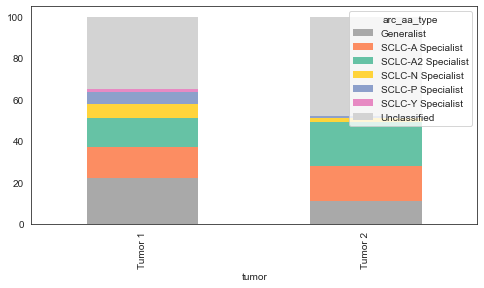

In [19]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='tumor', fname = 'tumor', pheno_name="arc_aa_type", custom_palette=color_dict)

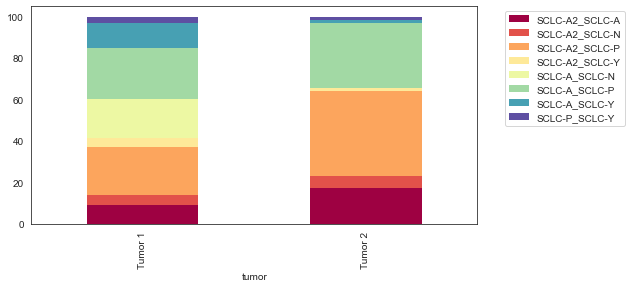

In [20]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/arc_aa_generalist_subtypes.pdf')

In [21]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
# mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='cline',color = 'arc_aa_type',
#                         order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
#                         figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


In [22]:
np.unique(adata.obs['arc_pheno'], return_counts=True)

(array(['SCLC-A', 'SCLC-A2', 'SCLC-A2_SCLC-A', 'SCLC-A2_SCLC-N',
        'SCLC-A2_SCLC-P', 'SCLC-A2_SCLC-Y', 'SCLC-A_SCLC-N',
        'SCLC-A_SCLC-P', 'SCLC-A_SCLC-Y', 'SCLC-N', 'SCLC-P',
        'SCLC-P_SCLC-Y', 'SCLC-Y', 'Unclassified'], dtype=object),
 array([150, 178,  18,   7,  44,   4,  12,  38,   9,  30,  23,   3,   4,
        408]))

In [23]:
adata.write_h5ad('../../out/PDX-tumors/adata_03.h5ad')



... storing 'Phenotype' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical


In [3]:
adata = sc.read_h5ad('../../out/PDX-tumors/adata_03.h5ad')


In [7]:
adata_copy = adata.copy()

In [8]:
adata_copy.X = adata.layers['log1p_norm_unscaled']

In [9]:
sc.pp.neighbors(adata_copy)
sc.tl.pca(adata_copy)
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)

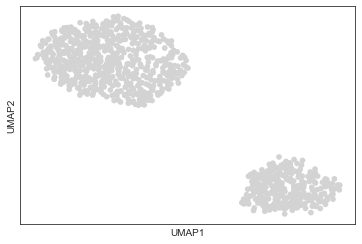

In [10]:
sc.pl.umap(adata_copy)

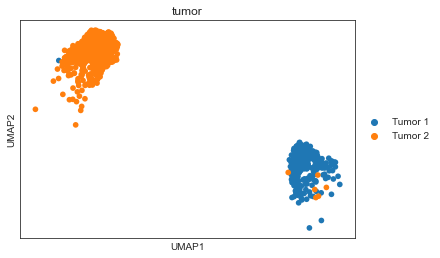

In [11]:
sc.pl.umap(adata, color = 'tumor')